In [1]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
qubit = 0

from qiskit import pulse

### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

from qiskit.circuit import Parameter      # This is Parameter Class for variable parameters.
from qiskit.circuit import QuantumCircuit, Gate

In [3]:
# The pulse simulator
from qiskit.providers.aer import PulseSimulator

# Object for representing physical models
from qiskit.providers.aer.pulse import PulseSystemModel

# Mock Armonk backend
from qiskit.providers.fake_provider import FakeArmonk

backend = FakeArmonk()

freq_est = 4.97e9
drive_est = 6.35e7
backend.defaults().qubit_freq_est = [freq_est]
backend.configuration().hamiltonian['h_str']= ['wq0*0.5*(I0-Z0)', 'omegad0*X0||D0']
backend.configuration().hamiltonian['vars'] = {'wq0': 2 * np.pi * freq_est, 'omegad0': drive_est}
backend.configuration().hamiltonian['qub'] = {'0': 2}
backend.configuration().dt = 2.2222222222222221e-10

armonk_model = PulseSystemModel.from_backend(backend)

In [5]:
from qiskit_aer import AerSimulator

backend_sim = AerSimulator.from_backend(FakeArmonk())

# Set the pulse system model for the simulator
#backend_sim.set_options(system_model=armonk_model)

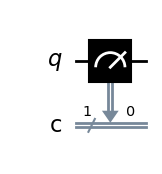

In [6]:
qc = QuantumCircuit(1, 1)
qc.measure(0, 0)
qc.draw('mpl')

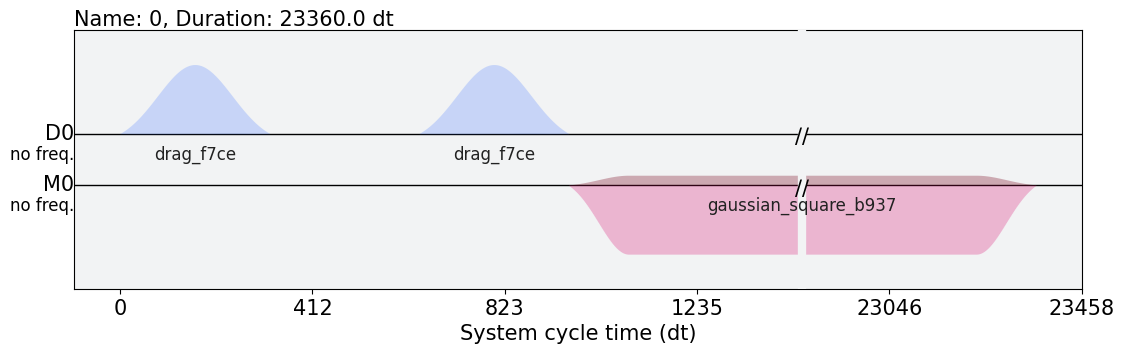

In [7]:
defaults = backend.defaults()
inst_sched_map = defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=[qubit])
x_pulse = inst_sched_map.get('x', qubits=[qubit])

# Create the schedules for 0 and 1
schedule_0 = pulse.Schedule(name='0')
schedule_0 += x_pulse
schedule_0 += x_pulse << schedule_0.duration
schedule_0 += measure << schedule_0.duration
schedule_1 = pulse.Schedule(name='1')
schedule_1 += x_pulse
schedule_1 += measure << schedule_1.duration

schedule_0.draw()

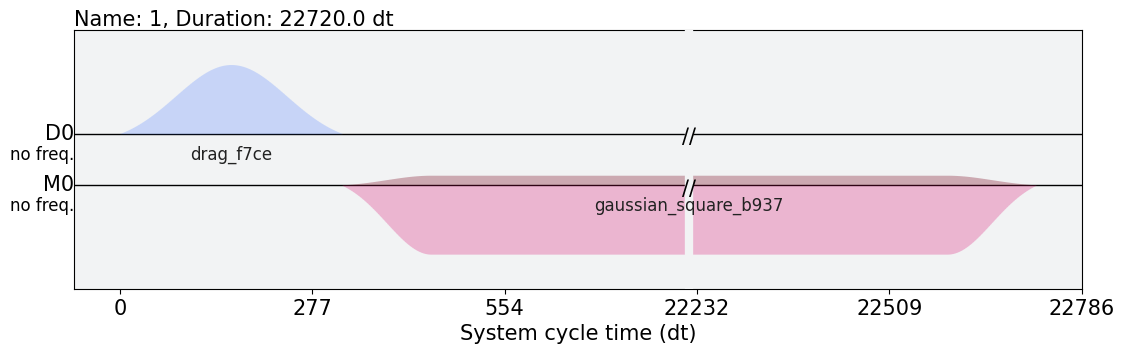

In [8]:
schedule_1.draw()

In [9]:
# unit conversion factors -> all backend properties returned in SI 
# (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
kHz = 1.0e3
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

frequency_span_Hz = 320 * kHz
frequency_step_Hz = 8 * kHz
center_frequency_Hz = defaults.meas_freq_est[qubit]
print(f"Qubit {qubit} has an estimated readout frequency of {center_frequency_Hz / GHz} GHz.")
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)
print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz\
      in steps of {frequency_step_Hz / MHz} MHz.")

Qubit 0 has an estimated readout frequency of 6.993370669000001 GHz.
The sweep will go from 6.993210669000001 GHz to 6.993530669000001 GHz      in steps of 0.008 MHz.


In [11]:
from qiskit import assemble
num_shots_per_frequency = 2048
frequencies_Hz = frequencies_GHz*GHz
schedule_los = [{meas_chan: freq} for freq in frequencies_Hz]

cavity_sweep_0 = assemble(schedule_0,
                               backend=backend_sim, 
                               meas_level=1,
                               meas_return='avg',
                               shots=num_shots_per_frequency,
                               schedule_los=schedule_los, absolute=False)
cavity_sweep_1 = assemble(schedule_1,
                               backend=backend_sim, 
                               meas_level=1,
                               meas_return='avg',
                               shots=num_shots_per_frequency,
                               schedule_los=schedule_los)

QiskitError: 'qubit_lo_freq must be supplied.'

In [10]:
#job_0 = backend.run(schedule_0, meas_level=1, meas_return='avg', shots=num_shots_per_frequency)
#job_1 = backend.run(schedule_1, meas_level=1, meas_return='avg', shots=num_shots_per_frequency)
cavity_sweep_0_results = backend_sim.run(cavity_sweep_0).result()
cavity_sweep_1_results = backend_sim.run(cavity_sweep_1).result()

In [24]:
cavity_sweep_0_results.results

[ExperimentResult(shots=2048, success=True, meas_level=1, data=ExperimentResultData(memory=[[0.0, 0.0]], statevector=[[1.0, 0.0], [0.0, 0.0]]), header=QobjExperimentHeader(memory_slots=1, name='0', metadata={}, ode_t=0.0), status=DONE, meas_return=avg, seed_simulator=745730825, time_taken=0.0005398610743080698),
 ExperimentResult(shots=2048, success=True, meas_level=1, data=ExperimentResultData(memory=[[0.0, 0.0]], statevector=[[1.0, 0.0], [0.0, 0.0]]), header=QobjExperimentHeader(memory_slots=1, name='0', metadata={}, ode_t=0.0), status=DONE, meas_return=avg, seed_simulator=1912672444, time_taken=0.0005398610743080698),
 ExperimentResult(shots=2048, success=True, meas_level=1, data=ExperimentResultData(memory=[[0.0, 0.0]], statevector=[[1.0, 0.0], [0.0, 0.0]]), header=QobjExperimentHeader(memory_slots=1, name='0', metadata={}, ode_t=0.0), status=DONE, meas_return=avg, seed_simulator=1318296541, time_taken=0.0005398610743080698),
 ExperimentResult(shots=2048, success=True, meas_level=1

In [25]:
scale_factor = 1e-14
sweep_values_0 = []
for i in range(len(cavity_sweep_0_results.results)):
    res_0 = cavity_sweep_0_results.get_memory(i)*scale_factor
    sweep_values_0.append(res_0[qubit])
sweep_values_1 = []
for i in range(len(cavity_sweep_1_results.results)):
    res_1 = cavity_sweep_1_results.get_memory(i)*scale_factor
    sweep_values_1.append(res_1[qubit])
    
plotx = frequencies_Hz/kHz
ploty_0 = np.abs(sweep_values_0)
ploty_1 = np.abs(sweep_values_1)

In [26]:
print(ploty_1)

[7.00195313e-15 7.13867188e-15 7.07519531e-15 7.17773438e-15
 6.85058594e-15 7.05078125e-15 6.98730469e-15 6.91894531e-15
 7.01660156e-15 6.99218750e-15 6.93847656e-15 6.91894531e-15
 7.09472656e-15 7.13378906e-15 7.18261719e-15 6.87011719e-15
 7.11425781e-15 7.03613281e-15 6.96777344e-15 6.93359375e-15
 7.00195313e-15 7.05566406e-15 7.26074219e-15 6.87988281e-15
 7.07031250e-15 7.19726562e-15 7.17285156e-15 7.12890625e-15
 7.04101563e-15 6.96289062e-15 7.21679687e-15 6.99707031e-15
 7.05078125e-15 6.99707031e-15 6.84082031e-15 7.06054687e-15
 6.95800781e-15 6.98730469e-15 6.91894531e-15 6.79199219e-15
 7.00683594e-15]


In [27]:
print(ploty_0)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


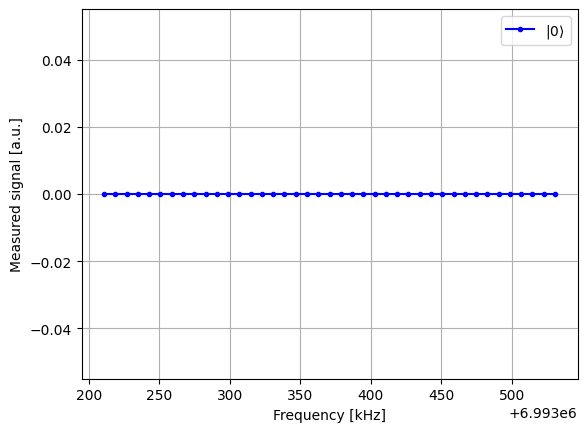

In [16]:
import matplotlib.pyplot as plt

# plot real part of sweep values
plt.plot(plotx, ploty_0, color='blue', marker='.')
# plot real part of sweep values 
plt.plot(plotx, ploty_1, color='red', marker='.') 
plt.legend([r'$\vert0\rangle$', r'$\vert1\rangle$'])
plt.grid()
plt.xlabel("Frequency [kHz]")
plt.ylabel("Measured signal [a.u.]")
plt.yscale('log')
plt.show()